In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import tqdm

import article

In [2]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [3]:
re_int = re.compile(r'[0-9]+')

def int_from_dir_path(dir_path):
    name = dir_path.name
    return int(re_int.search(name)[0])

In [4]:
PROJ_ROOT = pyprojroot.here()
RESULTS_ROOT = PROJ_ROOT / 'results' / 'Bengalese_Finches'
FIGS_ROOT  = PROJ_ROOT / 'doc' / 'article' / 'figures'

### Figure

In [5]:
sns.set("paper")

for the main figure, we further tweak the function `article.plot.error_curve.across_animals`

In [6]:
FIGSIZE = (7.5, 3.75)
DPI = 300


def error_across_animals_with_without_cleanup(curve_df, 
                                              cleanup,
                                              cleanup_str,
                                              none_text_xy=(0.5, 0.025),
                                              cleanup_text_xy=(0.5, 0.25),
                                              ax1_ylim=(0, 8),
                                              ax2_ylim=(0.1, 0.65),
                                              suptitle=None,
                                              figsize=FIGSIZE,
                                              dpi=DPI):
    if cleanup not in curve_df.cleanup.unique():
        raise ValueError(
            f'clean-up {cleanup} not found in unique values of '
            f'curve_df cleanup column: {curve_df.cleanup.unique()}'
        )
    TRAIN_DUR_IND_MAP = {
        k:v for k, v in zip(
            sorted(curve_df['train_set_dur'].unique()), 
            sorted(curve_df['train_set_dur_ind'].unique())
        )
    }

    fig = plt.figure(constrained_layout=False, figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(nrows=4, ncols=3, wspace=0.6)

    ax_arr = []
    ax_arr.append(fig.add_subplot(gs[0, 0]))
    ax_arr.append(fig.add_subplot(gs[1:, 0]))
    ax_arr.append(fig.add_subplot(gs[:, 1]))
    ax_arr.append(fig.add_subplot(gs[:, 2]))

    ax_arr = np.asarray(ax_arr)
    ax_arr[0].get_shared_x_axes().join(*ax_arr[:2].tolist())

    #for col in range(2):
    ax_arr[0].spines['bottom'].set_visible(False)
    ax_arr[1].spines['top'].set_visible(False)
    ax_arr[1].xaxis.tick_bottom()

    # ---- set up lists we iterate through to make figure
    metrics = [
        'avg_error', 
        'avg_segment_error_rate',
        'avg_segment_error_rate',
    ]
    cleanups = [
        'none', 
        'none',
        cleanup,
    ]
    ylabels = [
        'Frame error (%)', 
        'Segment error rate\n(edits per segment)', 
        'Segment error rate\n(edits per segment)',
    ]


    for col, (metric, cleanup, ylabel) in enumerate(zip(metrics, cleanups, ylabels)):
        ax = ax_arr[col + 1]  # skip ax_arr[0]

        if col == 2:  # legend only for last column
            legend = 'full'
        else:
            legend = False

        curve_df_cleanup = curve_df[curve_df.cleanup == cleanup]
        sns.lineplot(x='train_set_dur_ind', 
                     y=metric, 
                     hue='animal_id', 
                     data=curve_df_cleanup,
                     ci='sd',
                     palette='colorblind',
                     linewidth=2, 
                     ax=ax, 
                     legend=legend)
        sns.lineplot(x='train_set_dur_ind', 
                     y=metric, 
                     linestyle='dashed', 
                     color='k', 
                     linewidth=4, 
                     data=curve_df_cleanup,
                     ci=None, 
                     label='mean',
                     ax=ax, 
                     legend=legend)

        ax.set_ylabel('')

        ax.set_xlabel('Training set duration (s)', fontsize=10)
        ax.set_xticks(list(TRAIN_DUR_IND_MAP.values()))
        ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)


    ax_arr[0].set_xticklabels([])
    ax_arr[0].set_xlabel('')

    # zoom-in / limit the view to different portions of the data
    ax_arr[0].set_ylim(40, 100)
    ax_arr[1].set_ylim(ax1_ylim)
    ax_arr[2].set_ylim(ax2_ylim)
    ax_arr[3].set_ylim(ax2_ylim)

    x, y = none_text_xy
    ax_arr[2].text(x, y, 'clean-up:\nnone')
    x, y = cleanup_text_xy
    ax_arr[3].text(x, y, f'clean-up:\n{cleanup_str}')
    
    bigax_col0 = fig.add_subplot(gs[:, 0], frameon=False)
    bigax_col1 = fig.add_subplot(gs[:, 1], frameon=False)
    bigax_col2 = fig.add_subplot(gs[:, 2], frameon=False)
    labelpads = (2, 10, 10)
    panel_labels = ['A', 'B', 'C']
    for ylabel, labelpad, panel_label, ax in zip(ylabels,
                                                 labelpads,
                                                 panel_labels,
                                                 [bigax_col0, bigax_col1, bigax_col2]):
        ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        ax.grid(False)
        ax.set_ylabel(ylabel, fontsize=12, labelpad=labelpad)
        ax.text(-0.3, 1., panel_label, transform=ax.transAxes,
              fontsize=18, fontweight='bold', va='top', ha='right')

    # get handles from right axes legend, then remove and re-create outside
    handles, _ = ax_arr[-1].get_legend_handles_labels()
    [ha.set_linewidth(2) for ha in handles ]
    ax_arr[-1].get_legend().remove()
    bigax_col2.legend(handles=handles, bbox_to_anchor=(1.8, 1))

    if suptitle is not None:
        fig.suptitle(suptitle)
    
    return fig

Load source data, generate figure

In [7]:
HIDDEN_SIZE_FIGS_ROOT = fname = FIGS_ROOT / 'results' / 'Bengalese_Finches' / 'hidden_size'

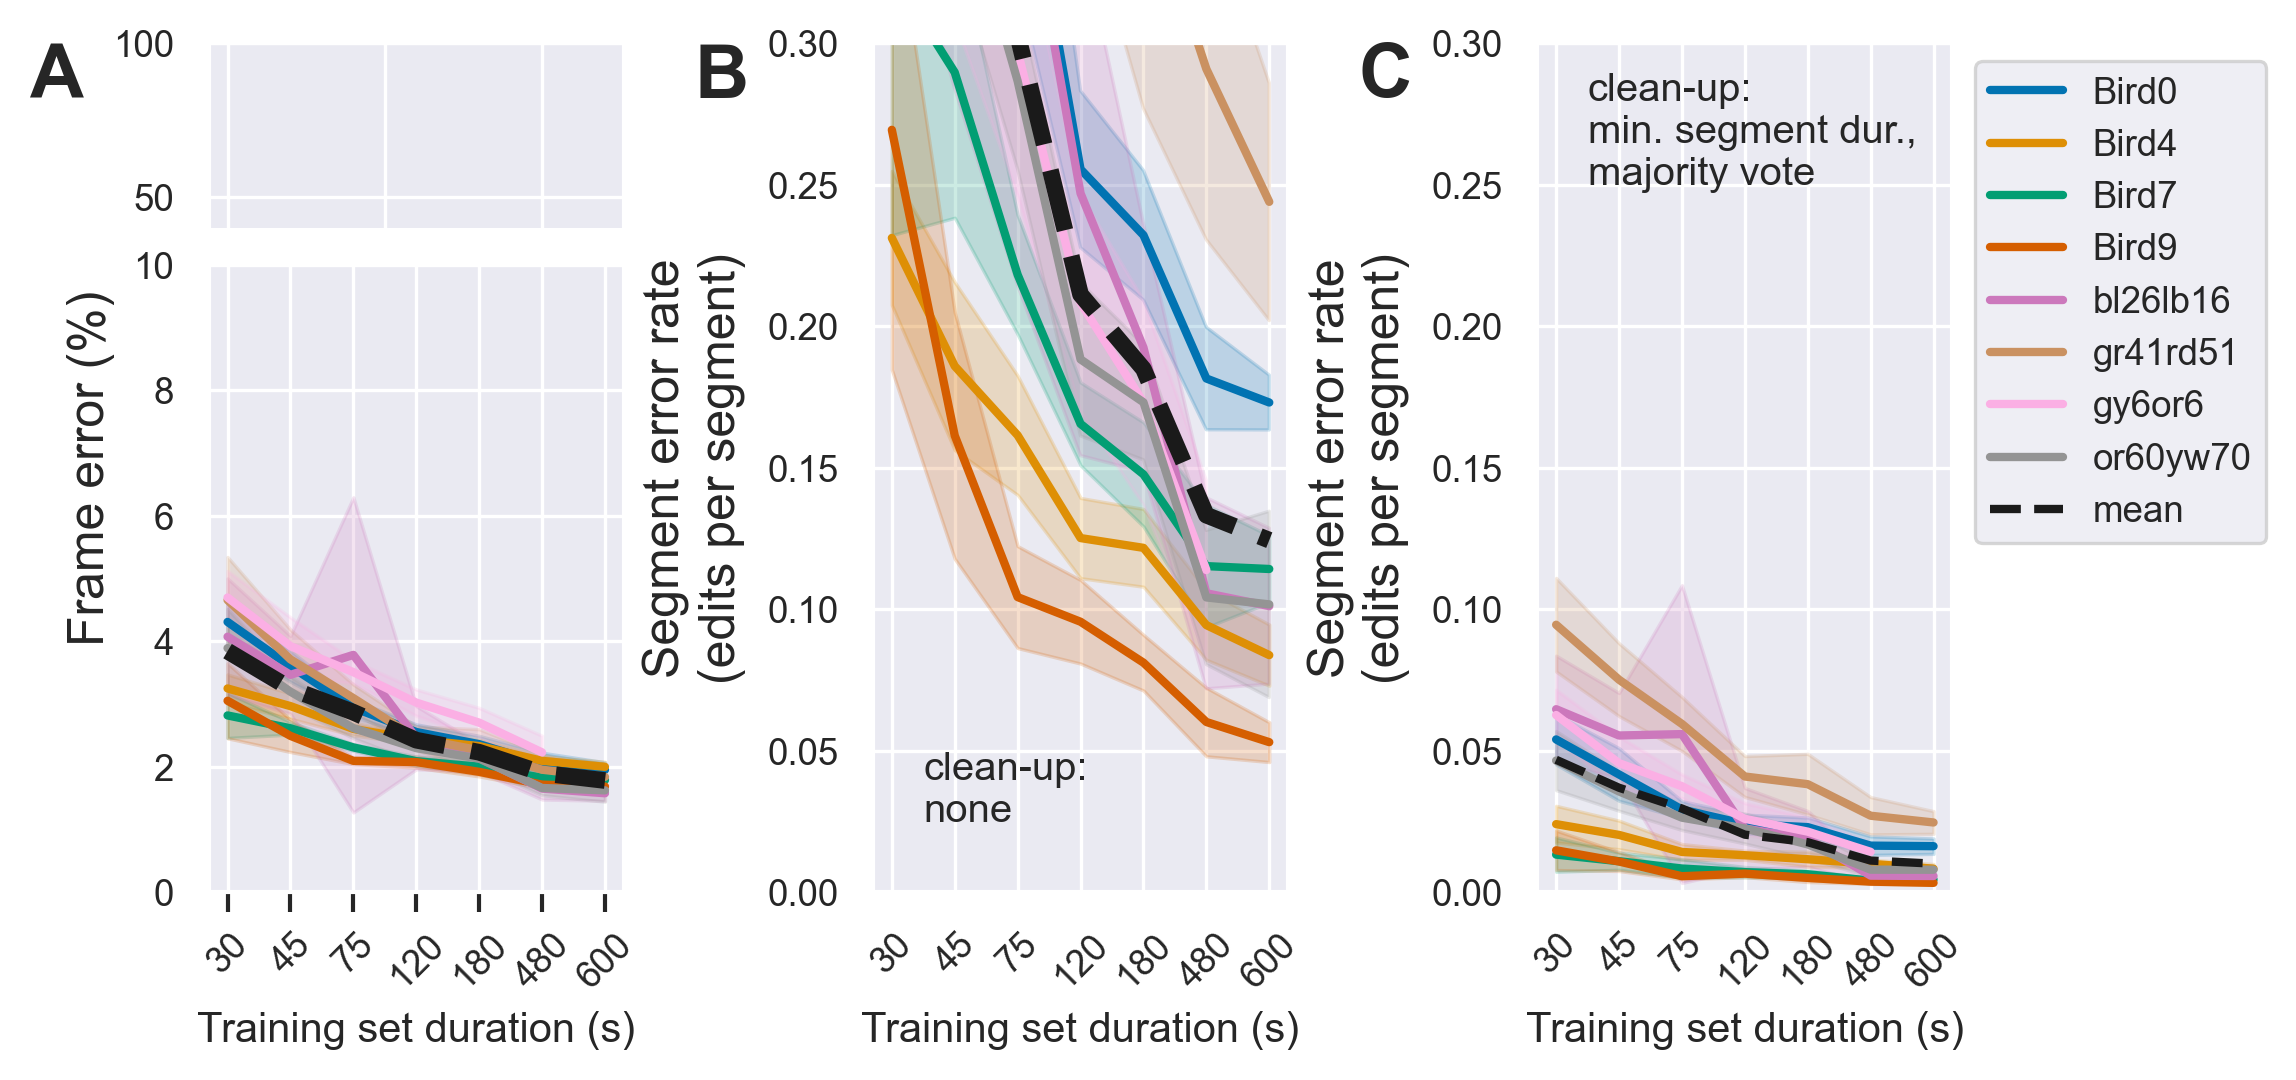

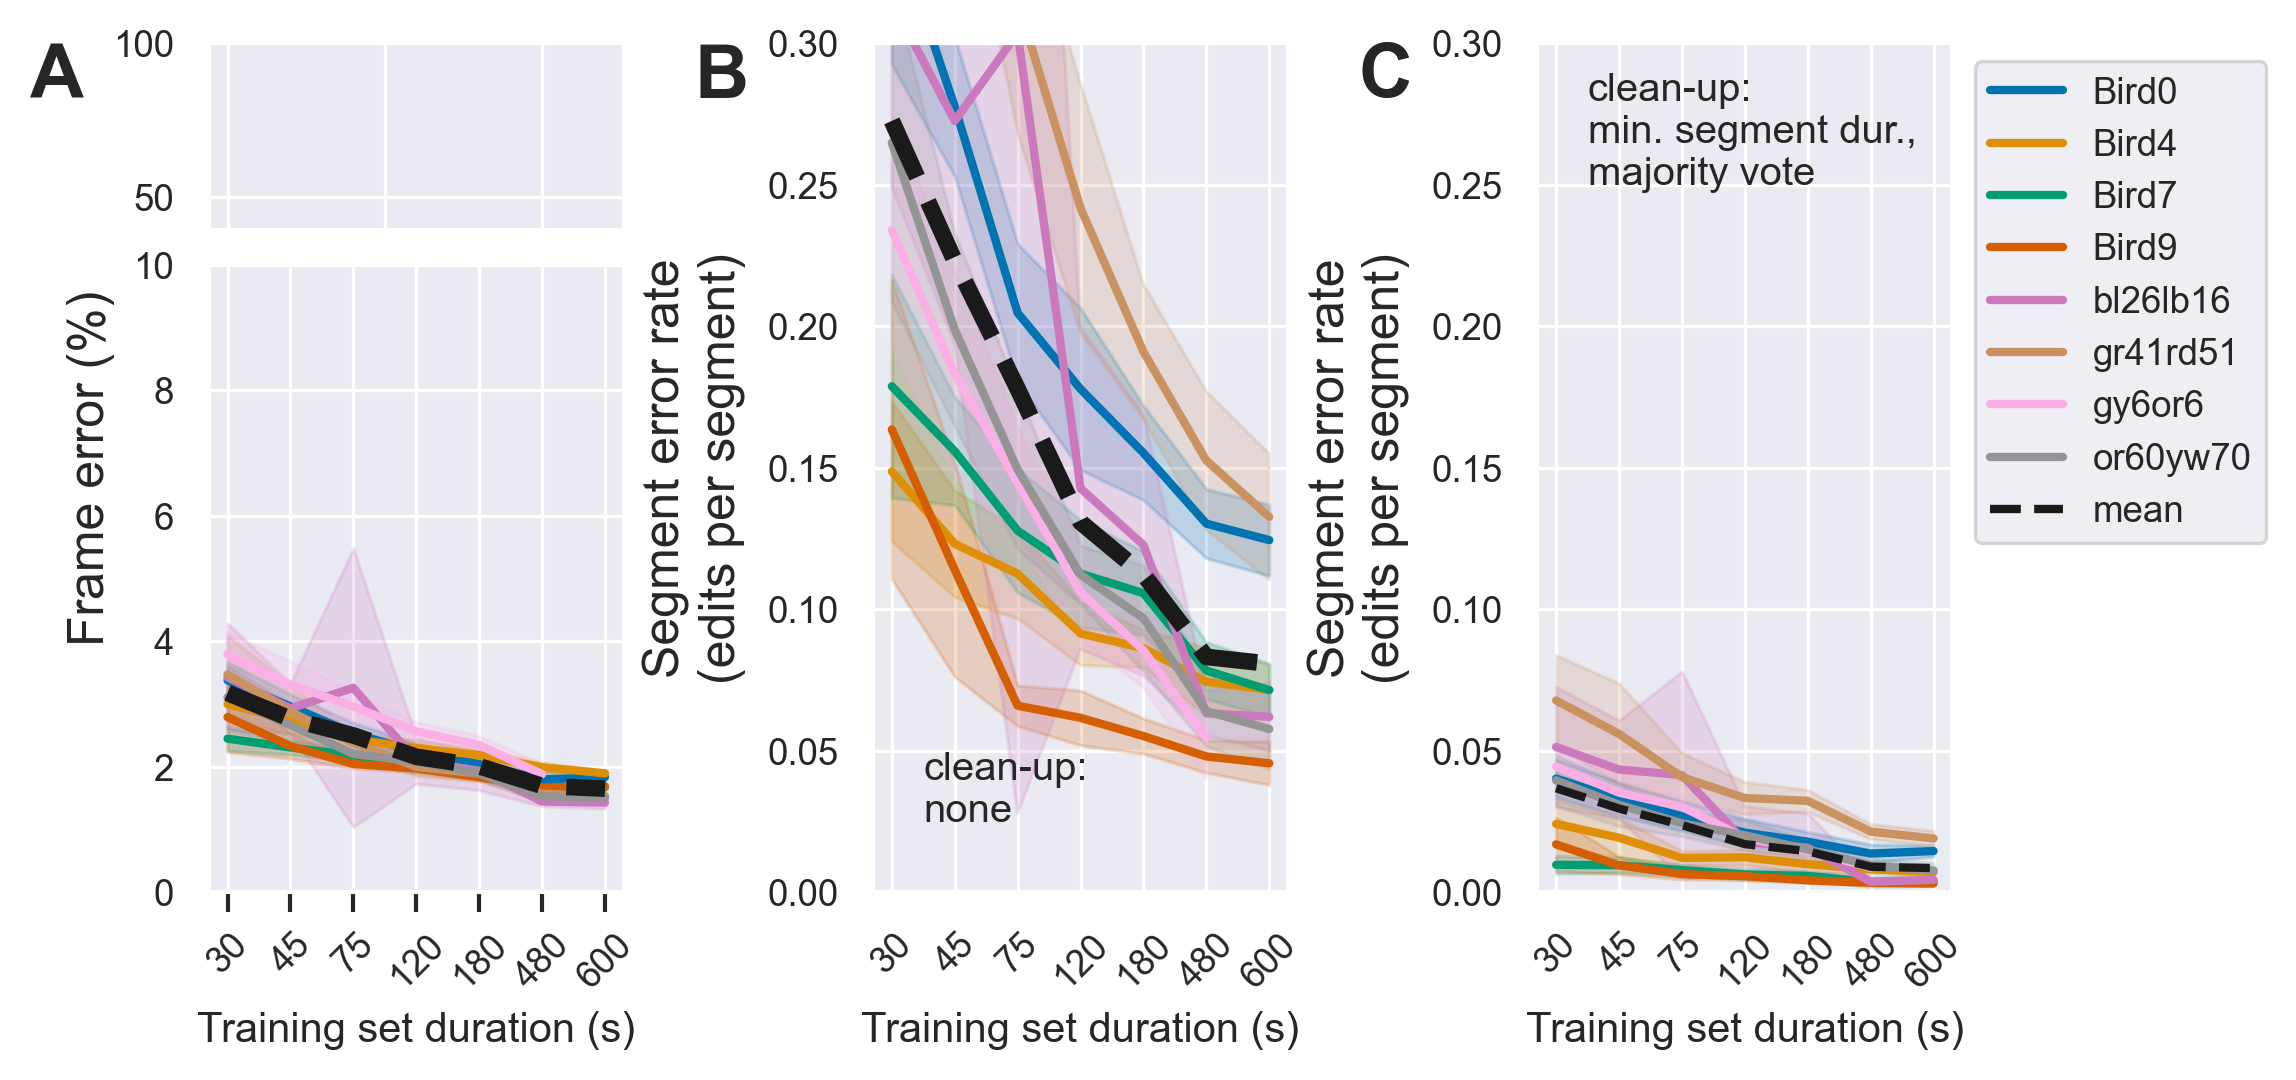

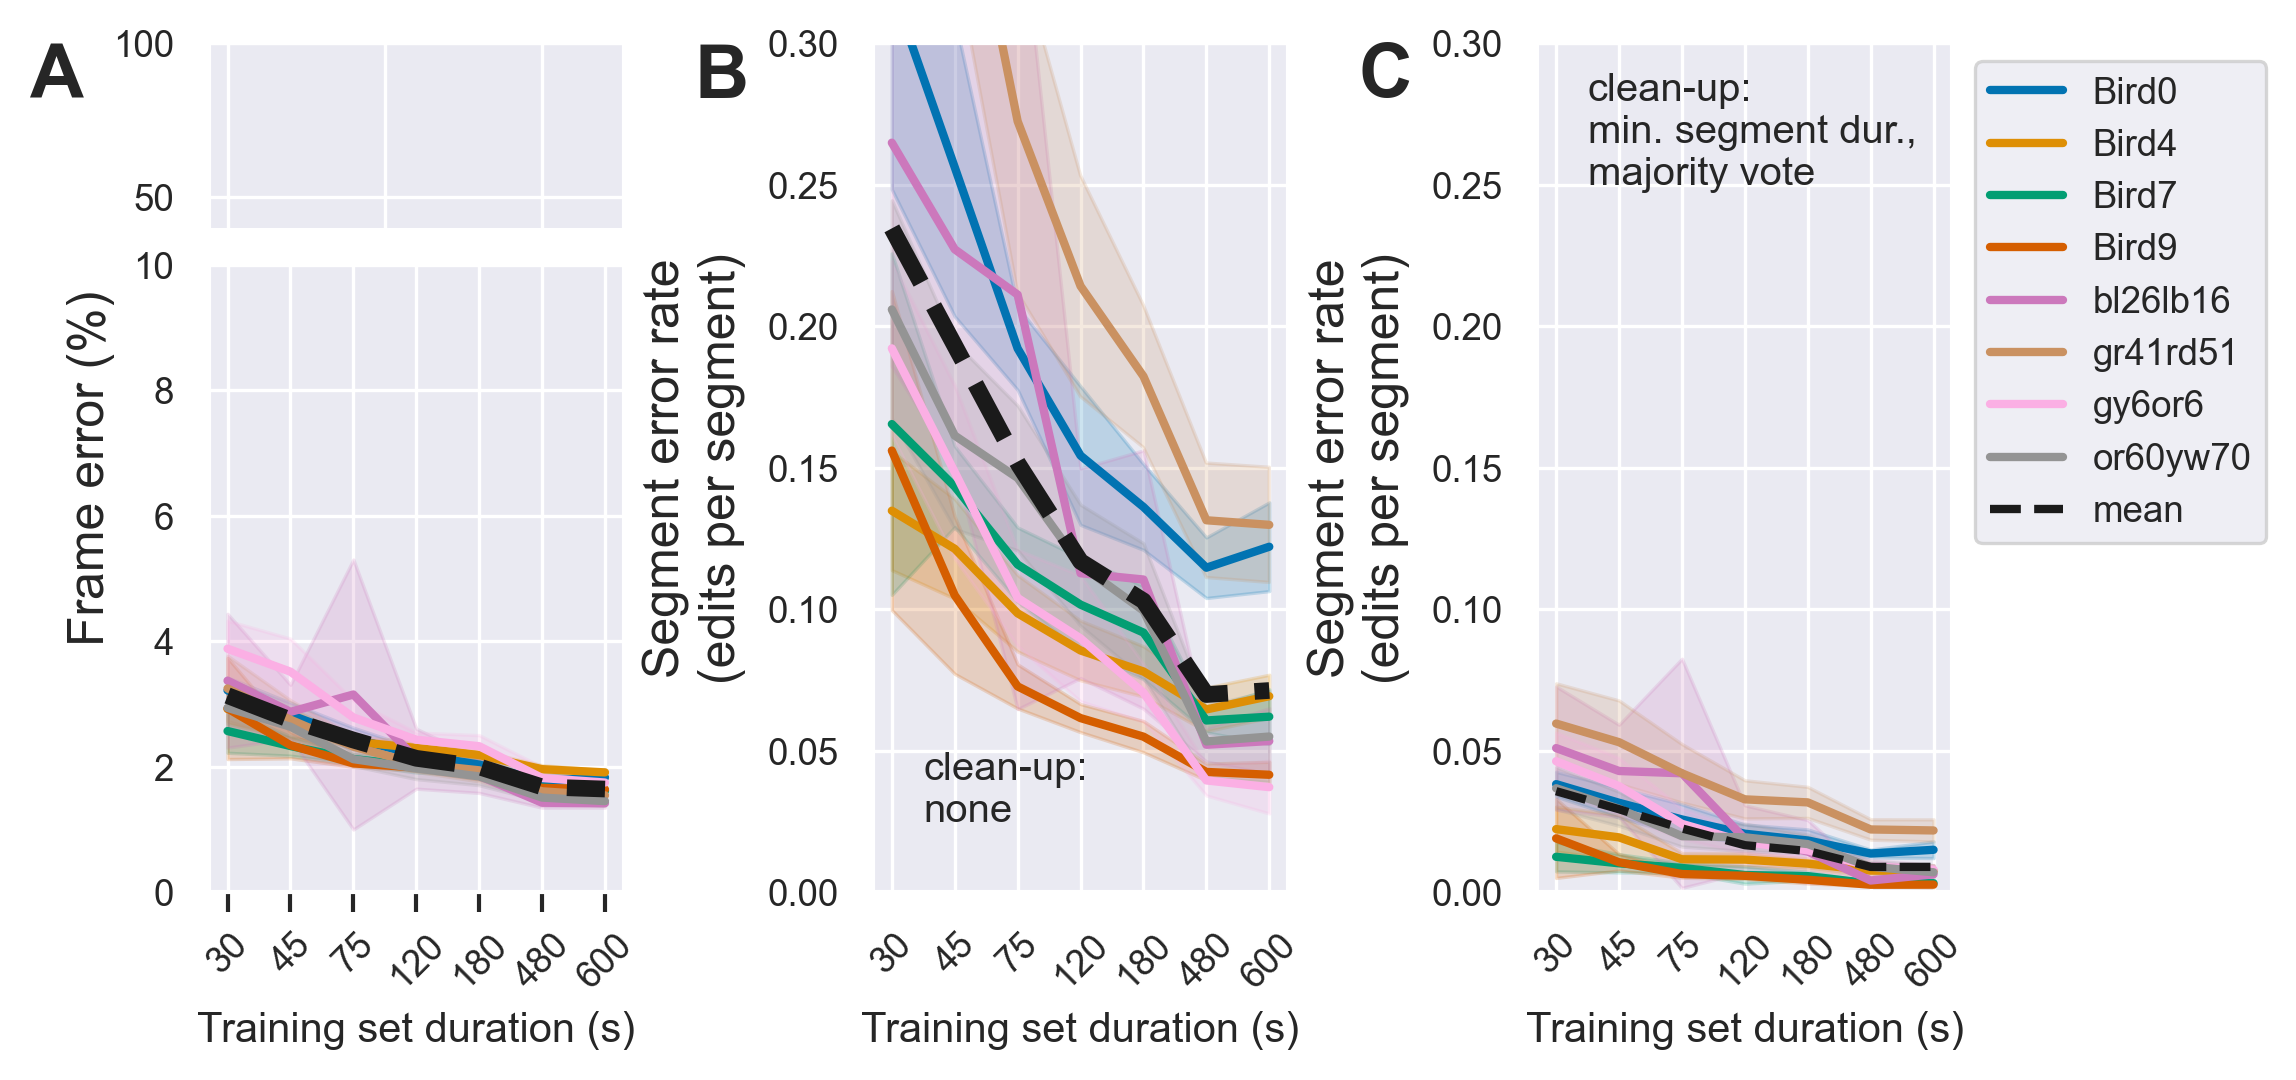

In [8]:
df_hidden_size = []

for hidden_size in (16, 64, 256):
    if hidden_size == 256:
        # 256 is the size we used for main figure results
        error_csv_path = RESULTS_ROOT / 'learncurve' / 'error_across_birds_with_cleanup.csv'
    else:
        error_csv_path = RESULTS_ROOT / 'hidden_size' / f'hidden_size_{hidden_size}' / 'error_across_birds_with_cleanup.csv'

    curve_df = pd.read_csv(error_csv_path)
    fig = error_across_animals_with_without_cleanup(curve_df,
                                                    cleanup='min_segment_dur_majority_vote',
                                                    cleanup_str='min. segment dur.,\nmajority vote',
                                                    ax1_ylim=(0,10),
                                                    ax2_ylim=(0., 0.3))
    fig.savefig(
        HIDDEN_SIZE_FIGS_ROOT / f'error-curves-hidden-size-{hidden_size}.png'
    )
    plt.show()
    
    df = curve_df.groupby(['cleanup', 'train_set_dur', 'train_set_dur_ind']).agg(
        mean_error=pd.NamedAgg(column="avg_error", aggfunc="mean"),
        mean_segment_error_rate=pd.NamedAgg(column="avg_segment_error_rate", aggfunc="mean"),
    ).reset_index()
    df['hidden_size'] = hidden_size
    df_hidden_size.append(df)

df_hidden_size = pd.concat(df_hidden_size)

In [9]:
FIGSIZE = (7.5, 3.75)
DPI = 300


def error_across_hidden_sizes(curve_df,
                              cleanup,
                              cleanup_str,
                              none_text_xy=(0.5, 0.025),
                              cleanup_text_xy=(0.5, 0.25),
                              ax1_ylim=(0, 8),
                              ax2_ylim=(0.1, 0.65),
                              suptitle=None,
                              figsize=FIGSIZE,
                              dpi=DPI):
    if cleanup not in curve_df.cleanup.unique():
        raise ValueError(
            f'clean-up {cleanup} not found in unique values of '
            f'curve_df cleanup column: {curve_df.cleanup.unique()}'
        )
    TRAIN_DUR_IND_MAP = {
        k:v for k, v in zip(
            sorted(curve_df['train_set_dur'].unique()), 
            sorted(curve_df['train_set_dur_ind'].unique())
        )
    }

    fig = plt.figure(constrained_layout=False, figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(nrows=4, ncols=3, wspace=0.6)

    ax_arr = []
    ax_arr.append(fig.add_subplot(gs[0, 0]))
    ax_arr.append(fig.add_subplot(gs[1:, 0]))
    ax_arr.append(fig.add_subplot(gs[:, 1]))
    ax_arr.append(fig.add_subplot(gs[:, 2]))

    ax_arr = np.asarray(ax_arr)
    ax_arr[0].get_shared_x_axes().join(*ax_arr[:2].tolist())

    #for col in range(2):
    ax_arr[0].spines['bottom'].set_visible(False)
    ax_arr[1].spines['top'].set_visible(False)
    ax_arr[1].xaxis.tick_bottom()

    # ---- set up lists we iterate through to make figure
    metrics = [
        'mean_error', 
        'mean_segment_error_rate',
        'mean_segment_error_rate',
    ]
    cleanups = [
        'none', 
        'none',
        cleanup,
    ]
    ylabels = [
        'Frame error (%)', 
        'Segment error rate\n(edits per segment)', 
        'Segment error rate\n(edits per segment)',
    ]


    for col, (metric, cleanup, ylabel) in enumerate(zip(metrics, cleanups, ylabels)):
        ax = ax_arr[col + 1]  # skip ax_arr[0]

        if col == 2:  # legend only for last column
            legend = 'full'
        else:
            legend = False

        curve_df_cleanup = curve_df[curve_df.cleanup == cleanup]

        sns.lineplot(x='train_set_dur_ind', 
                     y=metric, 
                     hue='hidden_size', 
                     data=curve_df_cleanup,
                     ci='sd',
                     palette='colorblind',
                     linewidth=2, 
                     ax=ax, 
                     legend=legend)

        ax.set_ylabel('')

        ax.set_xlabel('Training set duration (s)', fontsize=10)
        ax.set_xticks(list(TRAIN_DUR_IND_MAP.values()))
        ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)


    ax_arr[0].set_xticklabels([])
    ax_arr[0].set_xlabel('')

    # zoom-in / limit the view to different portions of the data
    ax_arr[0].set_ylim(40, 100)
    ax_arr[1].set_ylim(ax1_ylim)
    ax_arr[2].set_ylim(ax2_ylim)
    ax_arr[3].set_ylim(ax2_ylim)

    x, y = none_text_xy
    ax_arr[2].text(x, y, 'clean-up:\nnone')
    x, y = cleanup_text_xy
    ax_arr[3].text(x, y, f'clean-up:\n{cleanup_str}')
    
    bigax_col0 = fig.add_subplot(gs[:, 0], frameon=False)
    bigax_col1 = fig.add_subplot(gs[:, 1], frameon=False)
    bigax_col2 = fig.add_subplot(gs[:, 2], frameon=False)
    labelpads = (2, 10, 10)
    panel_labels = ['A', 'B', 'C']
    for ylabel, labelpad, panel_label, ax in zip(ylabels,
                                                 labelpads,
                                                 panel_labels,
                                                 [bigax_col0, bigax_col1, bigax_col2]):
        ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        ax.grid(False)
        ax.set_ylabel(ylabel, fontsize=12, labelpad=labelpad)
        ax.text(-0.3, 1., panel_label, transform=ax.transAxes,
              fontsize=18, fontweight='bold', va='top', ha='right')

    # get handles from right axes legend, then remove and re-create outside
    handles, _ = ax_arr[-1].get_legend_handles_labels()
    [ha.set_linewidth(2) for ha in handles ]
    ax_arr[-1].get_legend().remove()
    bigax_col2.legend(handles=handles, bbox_to_anchor=(1.8, 1))

    if suptitle is not None:
        fig.suptitle(suptitle)
    
    return fig

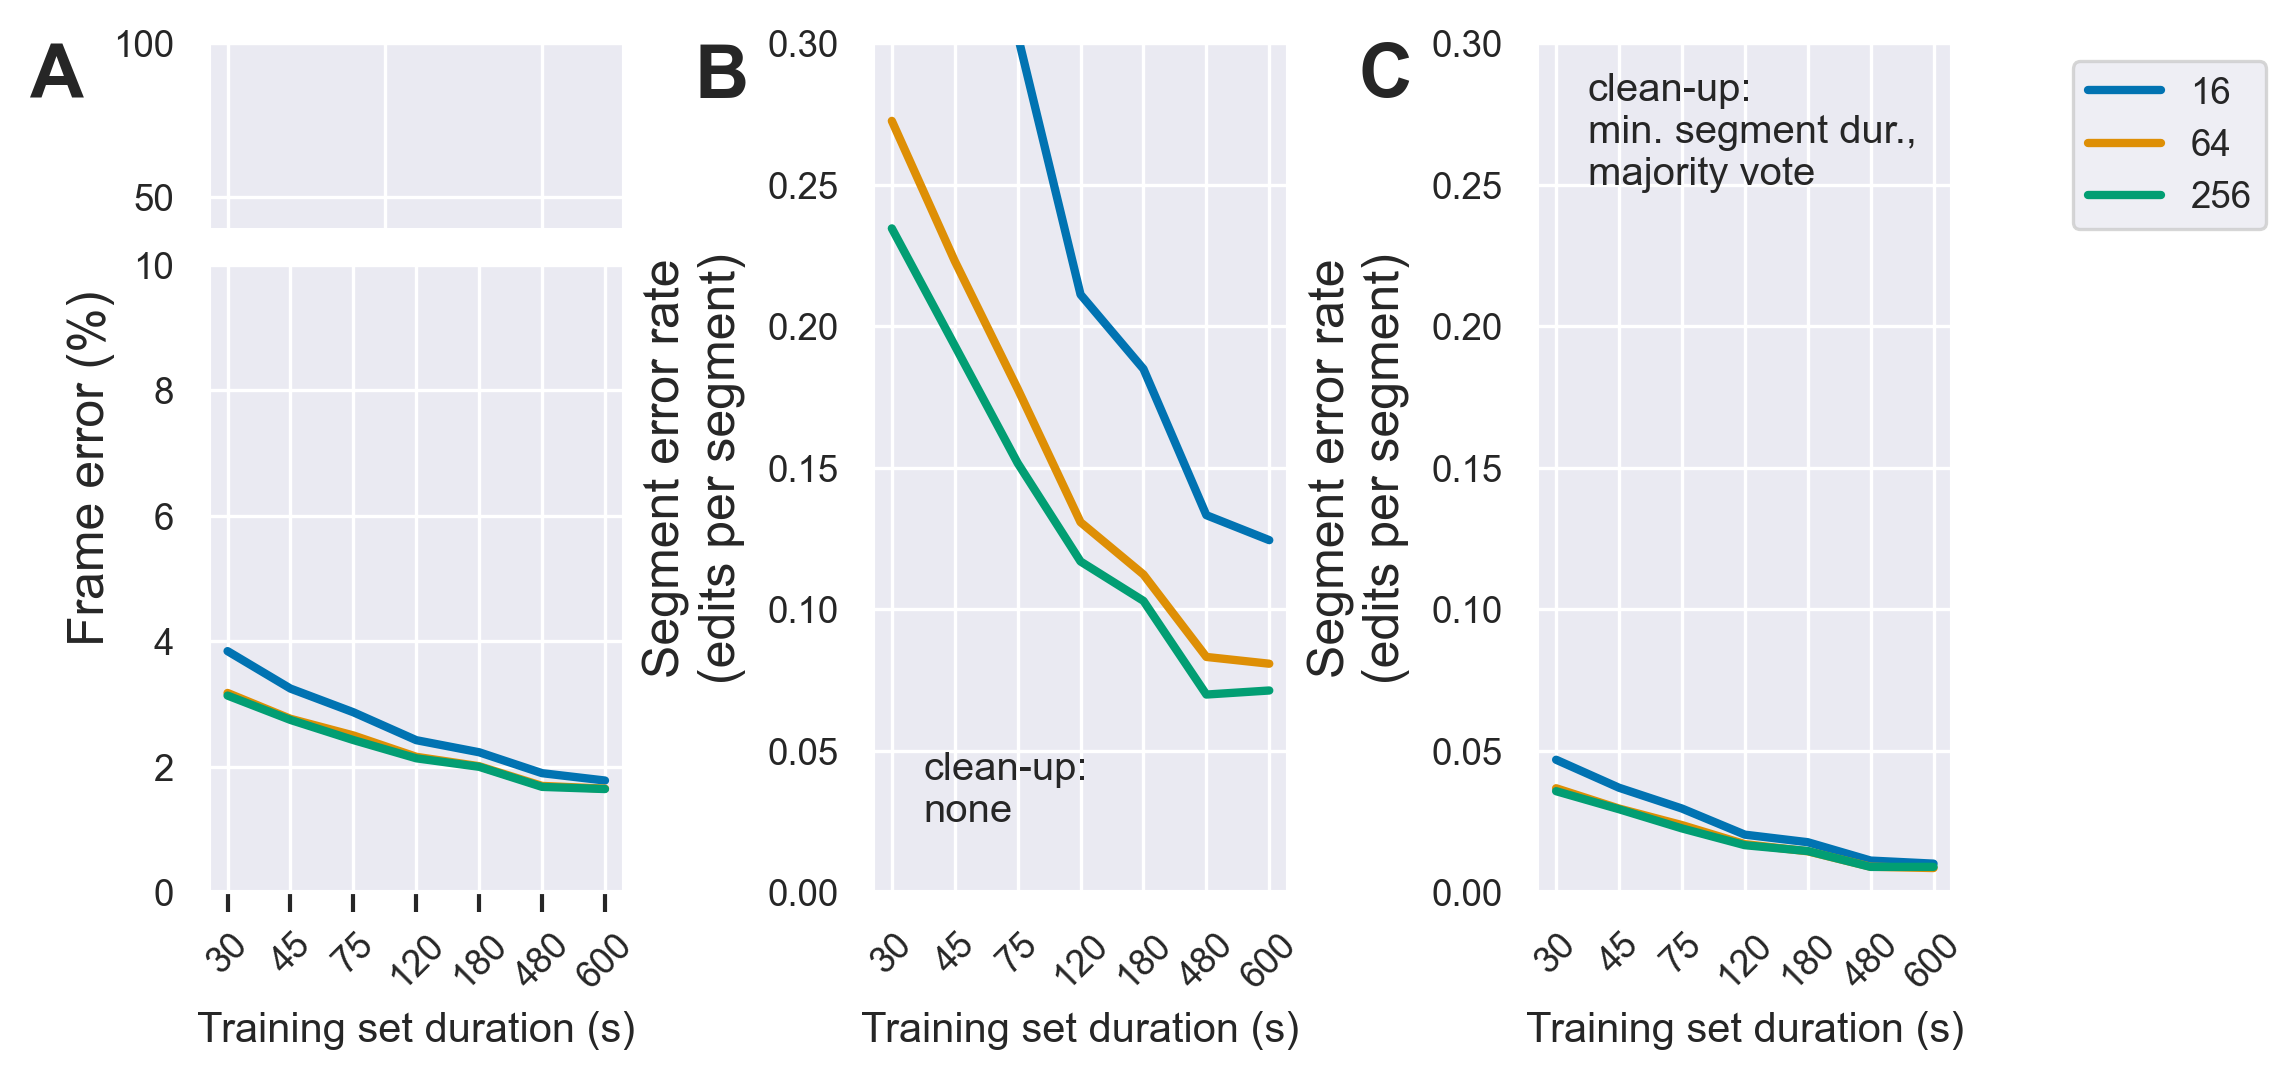

In [10]:
fig = error_across_hidden_sizes(df_hidden_size,
                                cleanup='min_segment_dur_majority_vote',
                                cleanup_str='min. segment dur.,\nmajority vote',
                                ax1_ylim=(0,10),
                                ax2_ylim=(0., 0.3))
fig.savefig(
        HIDDEN_SIZE_FIGS_ROOT / f'error-curves-all-hidden-sizes.png'
    )
plt.show()